# Preliminary operation and Import Packages

2.9 version of TensorFlow/Keras, some data augmentation techniques are particularly slow

In [ ]:
%pip install tensorflow-gpu==2.8.3 
%pip install -U scikit-learn

In [ ]:
%pip uninstall keras-preprocessing
%pip install git+https://github.com/keras-team/keras-preprocessing.git # flow_from_directory function in order to import image from pandas dataframe (map)

In [3]:
import tensorflow as tf 
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Image management
from skimage import io # Input/output
from skimage import transform # Geometric transformations (e.g. resize)
from skimage import filters # Local processing
from skimage import color # Change of color space
import cv2

from time import time
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

from sklearn.utils import resample
from sklearn.utils import shuffle

import pydot
import pydotplus
from pydotplus import graphviz

ModuleNotFoundError: No module named 'keras_preprocessing'

In [2]:
# Set the directory where the data is stored

path = 'C:/Users/marco/Desktop/Local_Documents/data'
os.chdir(path=path)

In [3]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [10,10] # width, height

# Load Data

## Import labels dataframe

In [4]:
# Import annotation (train, test)
train_label =pd.read_csv('train_COVIDx9A.txt', sep = ' ', header=None)
test_label = pd.read_csv('test_COVIDx9A.txt', sep= ' ', header=None)

In [5]:
# Set column names and remove unnecessary ones

train_label.columns=['patient id', 'img_path', 'label', 'data source']
train_label=train_label.drop(['patient id', 'data source'], axis=1 )

test_label.columns=['patient id', 'img_path', 'label', 'data source']
test_label=test_label.drop(['patient id', 'data source'], axis=1 )

In [6]:
train_label.head(5)

,img_path,label
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [7]:
test_label.head(5)

,img_path,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19


<AxesSubplot: xlabel='label', ylabel='Count'>

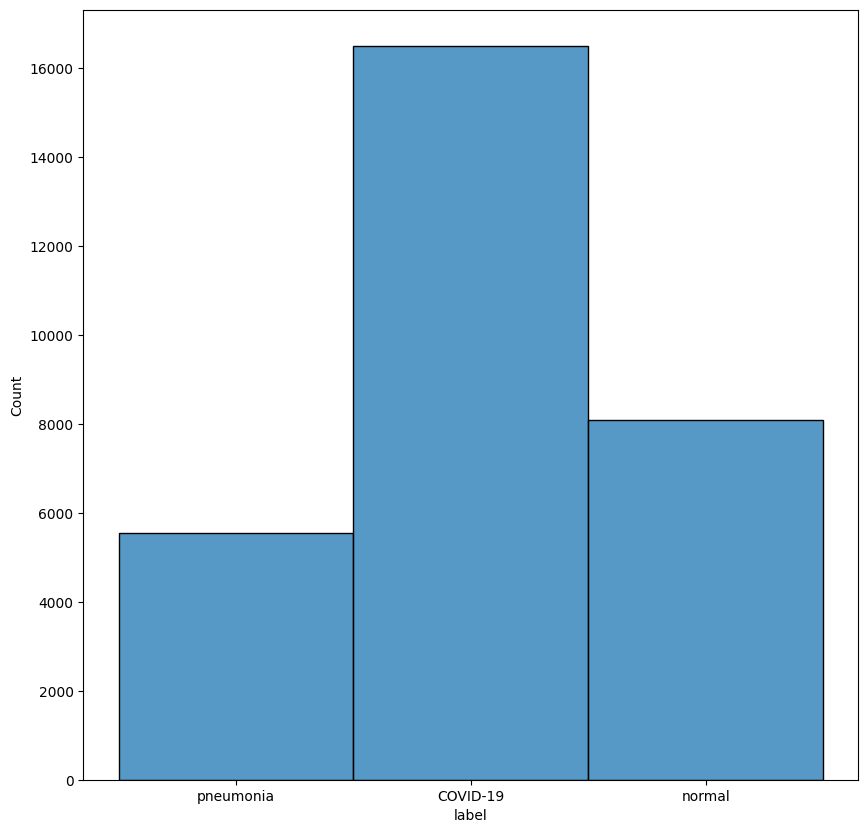

In [8]:
sns.histplot(train_label['label'], discrete=True)

In [9]:
train_label['label'].value_counts()

COVID-19     16490
normal        8085
pneumonia     5555
Name: label, dtype: int64

<AxesSubplot: xlabel='label', ylabel='Count'>

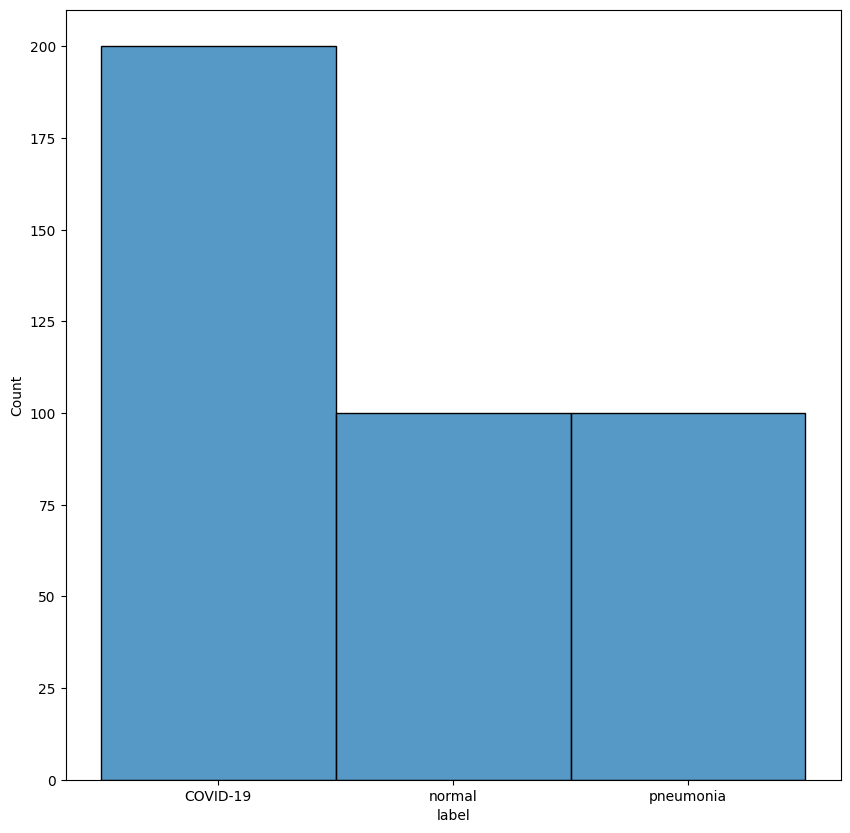

In [10]:
sns.histplot(test_label['label'], discrete=True)

In [11]:
test_label['label'].value_counts()

COVID-19     200
normal       100
pneumonia    100
Name: label, dtype: int64

# Image exploration

In this section different techniques for low-level processing of CXR images are explored

In [6]:
im = cv2.imread('../data/train/000db696-cf54-4385-b10b-6b16fbb3f985.png')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

In [7]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [8]:
# Image size
print('Image Dimension: ',im.shape)

Image Dimension:  (1024, 1024)


The size of the image is 1024x1024 and has 3 channels (RGB).

In order to carry out the necessary preprocessing, it is decided to resize the image to 224x224 and converting a image to grayscale

In [64]:
im = cv2.resize(im, (224,224))

In [65]:
print('Image Dimension: ',im.shape)

Image Dimension:  (224, 224)


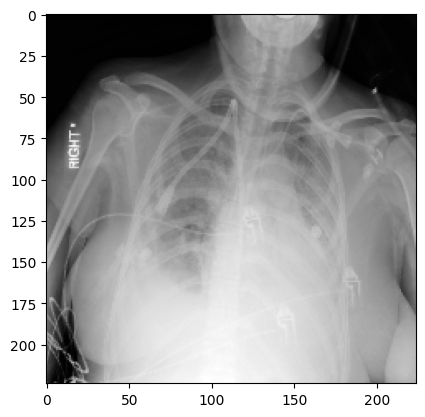

In [67]:
plt.imshow(im, cmap="gray")

## Blurring

The image is of good quality, although it is still possible to reduce noise, increase brightness, contrast, etc.

In [92]:
im_blur =cv2.GaussianBlur(im, None, sigmaX=0.8, sigmaY=0.8)

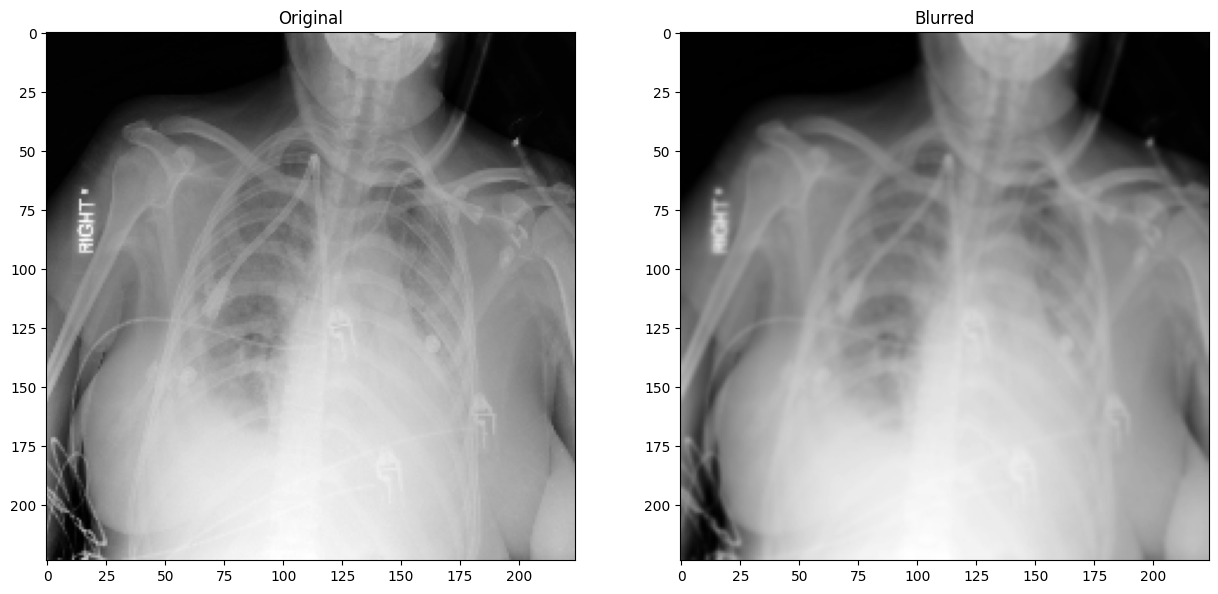

In [93]:
plt.subplot(1,2,1); plt.imshow(im, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(im_blur, cmap="gray"); plt.title('Blurred')
plt.show()

## Gamma correction

In [81]:
# Function for apply gamma correction 

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [105]:
im_gamma = adjust_gamma(im, gamma=0.6)

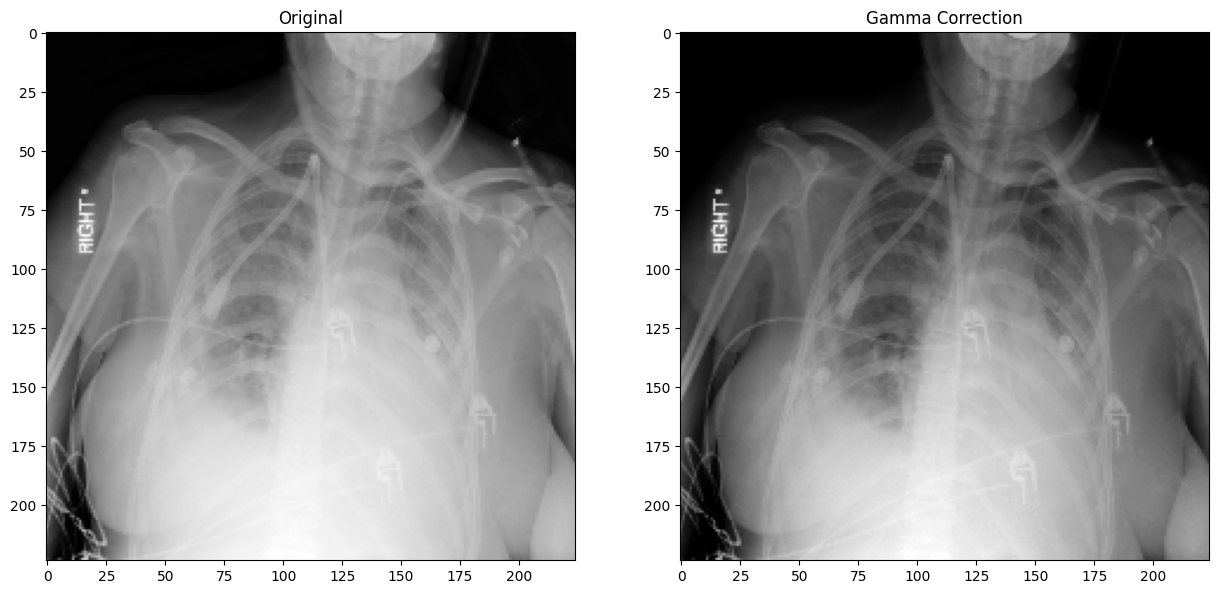

In [106]:
plt.subplot(1,2,1); plt.imshow(im, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(im_gamma, cmap="gray"); plt.title('Gamma Correction')
plt.show()

# Image Processing

### Adaptive Gamma Correction

Le seguenti funzioni implementano l'alogiritmo Adaptive Gamma Correction:

La funzione image_agcwd è il cuore dell'Adaptive Gamma Correction. La funzione riceve un'immagine e i parametri *a* e *truncated_cdf*, che determinano la forma della correzione. La funzione calcola l'istogramma dell'immagine, normalizza la distribuzione cumulativa e la distribuzione di probabilità. Poi esegue una trasformazione sulla distribuzione di probabilità, calcola la distribuzione cumulativa inversa e la utilizza per correggere la luminosità dell'immagine.

Infine, le funzioni **process_bright** e **process_dimmed** invocano la funzione **image_agcwd** con i parametri opportuni per elaborare le immagini luminose e oscure, rispettivamente.



1)  Lettura delle immagini dalla directory di input e creazione della directory di output se non esiste.
2)  Conversione di ogni immagine dal formato BGR a YCrCb.
3)  Calcolo della media di intensità dell'immagine Y (canale della luminosità).
4)  Determinazione della luminosità dell'immagine:
    -   Se la media di intensità è inferiore a una soglia, l'immagine viene considerata "oscura" e viene elaborata con la funzione process_dimmed.
    -   Se la media di intensità è superiore a una soglia, l'immagine viene considerata "luminosa" e viene elaborata con la funzione process_bright.
    -   Altrimenti, l'immagine viene considerata "corretta" e non viene elaborata.
5)  Salvataggio delle immagini elaborate nella directory di output.

In [ ]:
def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

In [ ]:
def apply_AGCWD(input_dir, output_dir):
    img_paths = glob.glob(input_dir+'*')
    total_count= 0
    dimmed_count= 0
    brighted_count = 0
    for path in img_paths:
        total_count +=1
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert to BGR
        img = cv2.resize(img, (224,224)) # Resize to 224x224
        name = path.split('\\')[-1].split('.')[0]
        
        # Extract intensity component of the image
        YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        Y = YCrCb[:,:,0]
        # Determine whether image is bright or dimmed
        threshold = 0.3
        exp_in = 112 # Expected global average intensity 
        M,N = img.shape[:2]
        mean_in = np.sum(Y/(M*N)) 
        t = (mean_in - exp_in)/ exp_in
        
        # Process image for gamma correction
        img_output = None
        if t < -threshold: # Dimmed Image
            dimmed_count += 1
            print (name + ": Dimmed")
            result = process_dimmed(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        elif t > threshold:
            brighted_count += 1
            print (name + ":Bright") # Bright Image
            result = process_bright(Y)
            YCrCb[:,:,0] = result
            img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        else:
            print('None')
            img_output = img
            img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)

        cv2.imwrite(output_dir+name+'.png', img_output)
    print("Numero totale di immagini processate: {}".format(total_count))
    print("Numero di immagini dimmed: {}".format(dimmed_count))
    print("Numero di immagini brighted: {}".format(brighted_count))
    return

In [ ]:
input_dir = 'C:\\Users/marco\\Desktop\\Local_Documents\\data\\train\\'
output_dir = 'C:\\Users\\marco\\Desktop\\Local_Documents\\data\\train_AGCWD\\'
apply_AGCWD(input_dir=input_dir, output_dir=output_dir)

000001-1:Bright
None
000001-10:Bright
000001-11:Bright
None
000001-13:Bright
None
000001-15:Bright
None
000001-18:Bright
None
000001-2:Bright
None
None
000001-266:Bright
None
None
None
None
000001-4:Bright
000001-4:Bright
000001-5:Bright
000001-6:Bright
None
None
None
000001-9-a:Bright
None
None
000001:Bright
None
None
000002-3:Bright
000002-4:Bright
None
None
None
None
None
None
None
None
None
000003-5:Bright
None
None
None
000004:Bright
000004:Bright
None
None
None
None
None
000006-17:Bright
None
None
None
None
000007:Bright
None
None
None
000010:Bright
None
000012-1:Bright
None
None
000016:Bright
None
None
None
None
None
None
None
None
None
0025d2de-bd78-4d36-9f72-e15a5e22ca82:Bright
None
None
None
None
None
None
None
006f3a8a: Dimmed
None
None
None
None
00aecb01-a116-45a2-956c-08d2fa55433f: Dimmed
None
None
00ddefb9-d94e-4e86-b945-970be30483d7:Bright
00ec0d87-8e2a-44bd-b79c-4b91cfabcacf:Bright
None
None
None
None
None
None
None
None
0124882b-de2f-4023-985f-debb74aa6ebb:Bright
None


In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/3a81faf3.jpg'
input_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train/'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img_paths = glob.glob(input_dir+'*')
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

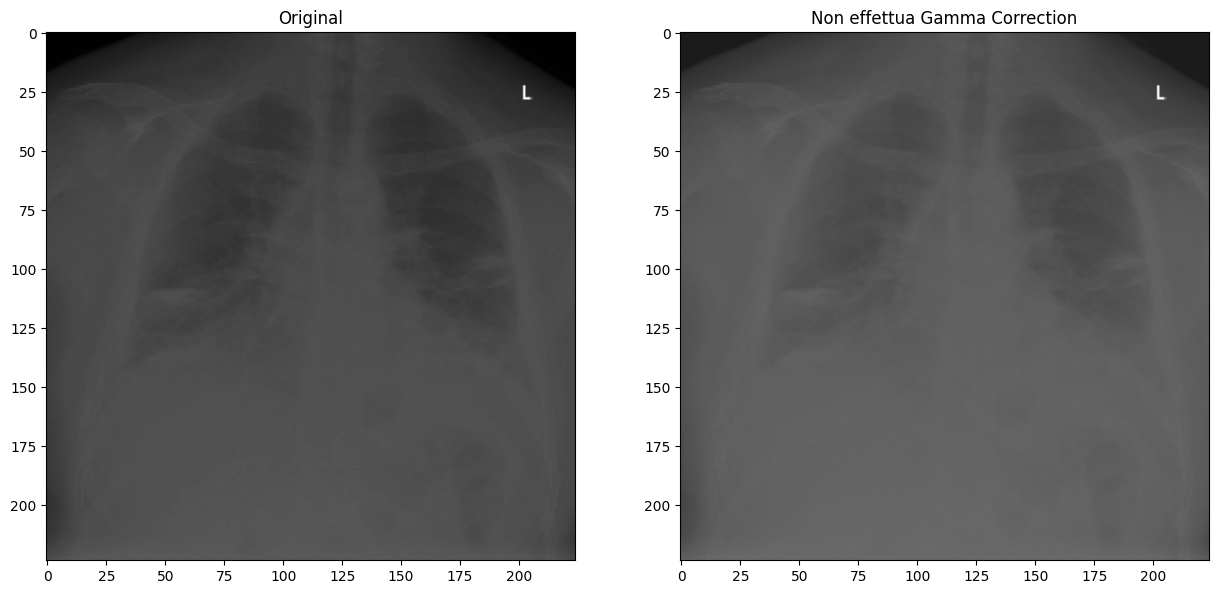

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/3a81faf3.jpg'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Oscura"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Schiarisce"
    print (name + ": Schiarito") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

C:/Users/marco/Desktop/Local_Documents/data/train/4b6cf439-a0a3-485f-8de9-950ee632cbca: Bright


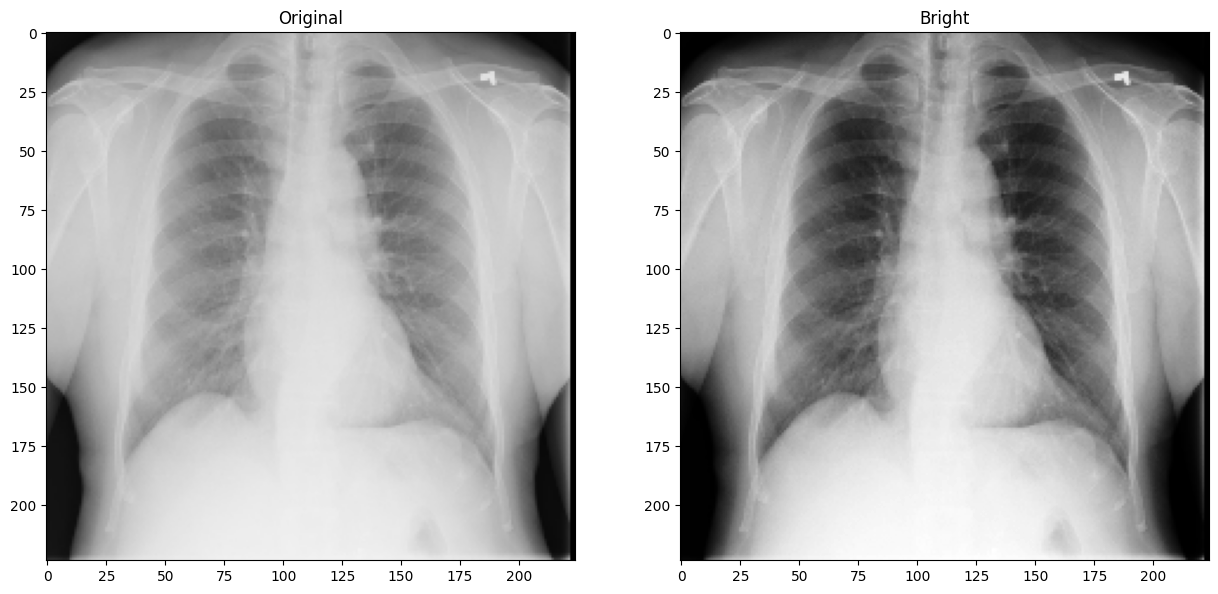

In [ ]:
img_paths = 'C:/Users/marco/Desktop/Local_Documents/data/train/4b6cf439-a0a3-485f-8de9-950ee632cbca.png'
output_dir = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('\\')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Bright"
    print (name + ": Bright") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

7a443f19-987a-4fff-a41a-65b9114fe53e: Oscurato


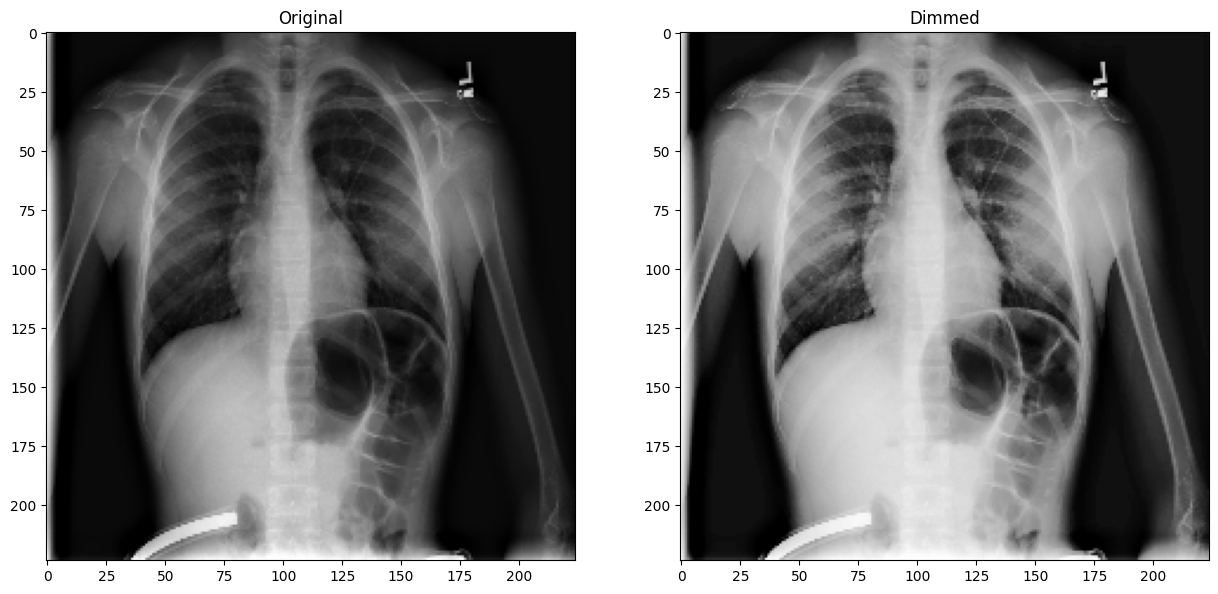

In [ ]:
img_paths = "C:/Users/marco/Desktop/tr/7a443f19-987a-4fff-a41a-65b9114fe53e.png"
output_dir = "C:/Users/marco/Desktop/tr_nuovo/"
img = cv2.imread(img_paths)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (224,224))
name = img_paths.split('/')[-1].split('.')[0]

# Extract intensity component of the image
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
# Determine whether image is bright or dimmed
threshold = 0.3
exp_in = 112 # Expected global average intensity 
M,N = img.shape[:2]
mean_in = np.sum(Y/(M*N)) 
t = (mean_in - exp_in)/ exp_in

# Process image for gamma correction
img_output = None
if t < -threshold: # Dimmed Image
    res = "Dimmed"
    print (name + ": Oscurato")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
elif t > threshold:
    res = "Bright"
    print (name + ": Bright") # Bright Image
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
else:
    res = 'Non effettua Gamma Correction'
    img_output = img
    img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
cv2.imwrite(output_dir+name+'.png', img_output)
plt.subplot(1,2,1); plt.imshow(img, cmap="gray"); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_output, cmap="gray"); plt.title(res)
plt.show()

# Class Imbalance

## Undersampling

In [12]:
train_label['label'].value_counts()

COVID-19     16490
normal        8085
pneumonia     5555
Name: label, dtype: int64

In [13]:
COVID_19  = train_label[train_label['label']=='COVID-19']   #negative values in label column
normal = train_label[train_label['label']=='normal']  #positive values in label column
pneumonia = train_label[train_label['label']=='pneumonia']

df_COVID_19 = resample(COVID_19, replace = True, n_samples = 5555)
df_normal = resample(normal, replace = True, n_samples = 5555)

train_label_under = pd.concat([pneumonia, df_COVID_19, df_normal])

train_label_under = shuffle(train_label_under) 

In [14]:
train_label_under['label'].value_counts()

COVID-19     5555
normal       5555
pneumonia    5555
Name: label, dtype: int64

In [15]:
train_label_under, val_label_under = train_test_split(train_label_under, train_size=0.9, random_state=0)

In [16]:
print(f"Negative and positive values of train: \n {train_label_under['label'].value_counts()}")
print(f"Negative and positive values of validation:\n {val_label_under['label'].value_counts()}")
print(f"Negative and positive values of test: \n{test_label['label'].value_counts()}")

Negative and positive values of train: 
 COVID-19     5049
pneumonia    4985
normal       4964
Name: label, dtype: int64
Negative and positive values of validation:
 normal       591
pneumonia    570
COVID-19     506
Name: label, dtype: int64
Negative and positive values of test: 
COVID-19     200
normal       100
pneumonia    100
Name: label, dtype: int64


## Data Augmentation

# Data loading

https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

## Original images

In [33]:
target_size = (224,224) # Target size
batch_size = 64 # Batch size

train_path = 'C:/Users/marco/Desktop/Local_Documents/data/train/'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/test/'   

train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [34]:
os.chdir(train_path)

#Training set
train_data = train_datagen.flow_from_dataframe(
dataframe=train_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 14866 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 132 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [35]:
os.chdir(train_path)

# Validation set
validation_data = test_datagen.flow_from_dataframe(
dataframe=val_label_under,
directory=train_path,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 1650 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 17 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [36]:
os.chdir(test_path)

# Test set
test_data = test_datagen.flow_from_dataframe(
dataframe=test_label,
directory=test_path,
x_col="img_path",
y_col=None,
batch_size=batch_size,
seed=123,
shuffle=False,
class_mode=None,
target_size=target_size)

Found 400 validated image filenames.


In [21]:
class_names = train_data.class_indices
print(class_names)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


## Gamma correction images

In [37]:
target_size = (224,224) # Target size
batch_size = 64 # Batch size

train_path_gc = 'C:/Users/marco/Desktop/Local_Documents/data/train_AGCWD/'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/test/'   

train_datagen_gc = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [38]:
os.chdir(train_path)

#Training set
train_datagen_gc = train_datagen.flow_from_dataframe(
dataframe=train_label_under,
directory=train_path_gc,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 10557 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 4441 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [39]:
os.chdir(train_path)

# Validation set
validation_data_gc = test_datagen.flow_from_dataframe(
dataframe=val_label_under,
directory=train_path_gc,
x_col="img_path",
y_col="label",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 1207 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 460 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [40]:
os.chdir(test_path)

# Test set
test_data = test_datagen.flow_from_dataframe(
dataframe=test_label,
directory=test_path,
x_col="img_path",
y_col=None,
batch_size=batch_size,
seed=123,
shuffle=False,
class_mode=None,
target_size=target_size)

Found 400 validated image filenames.


# Deep Convolutional Neural Network

In [41]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [48]:
version = "v1"
arc = "a1"
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/cnn_model__fs_{version}_{arc}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## 1. CNN from scratch

-  Downsample dataset
- No image processing
- No data Augmentation
- 30 epochs 

In [43]:
num_classes = 3

In [50]:
# Architecture definition
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_cnn_1 = keras.Model(inputs, outputs)

In [49]:
net_cnn_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 75, 75, 64)        0         
                                                           

In [80]:
keras.utils.plot_model(net, to_file=f'C:/Users/marco/Desktop/Local_Documents/model/plot/{version}/cnn_schema_fs_{version}_{arc}.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [52]:
# Compile the model for training
net_cnn_1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [53]:
history_cnn_1 = net_cnn_1.fit_generator(train_data,
          epochs=100,
          validation_data=validation_data,
          workers = 1,
          callbacks=[model_checkpoint_callback, early_stopper])

C:\Users\marco\AppData\Local\Temp\ipykernel_10784\4285332846.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn_1 = net_cnn_1.fit_generator(train_data,


Epoch 1/100
233/233 [==============================] - 333s 1s/step - loss: 0.7790 - accuracy: 0.6741 - val_loss: 0.6462 - val_accuracy: 0.7170
Epoch 2/100
 55/233 [======>.......................] - ETA: 3:48 - loss: 0.6399 - accuracy: 0.7378

In [ ]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/cnn_1_fs_{version}_{arc}.npy',
        history_cnn_1.history)

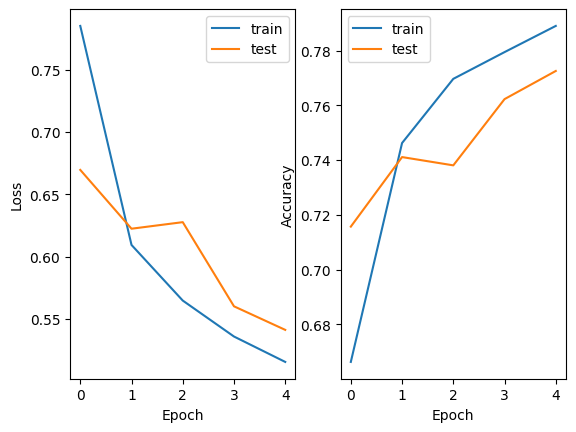

In [ ]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_cnn_1.history_cnn_1['loss'])
plt.plot(history_cnn_1.history_cnn_1['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_1.history_cnn_1['accuracy'])
plt.plot(history_cnn_1.history_cnn_1['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

## 2. CNN from scratch - Adaptive Gamma Correction

-  Downsample dataset
- Adaptive Gamma Correction
- No data Augmentation
- 30 epochs 

In [ ]:
num_classes = 3

In [ ]:
# Architecture definition
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_cnn_gc = keras.Model(inputs, outputs)

In [ ]:
net_cnn_gc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 75, 75, 64)        0         
                                                           

In [ ]:
# Compile the model for training
net_cnn_gc.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

NameError: name 'net_cnn_gc' is not defined

In [ ]:
history_cnn_agc = net_cnn_gc.fit_generator(train_datagen_gc,
          epochs=100,
          validation_data=validation_data,
          workers = 1,
          callbacks=[model_checkpoint_callback, early_stopper])

In [ ]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/cnn_gc_fs_{version}_{arc}.npy',
        history_cnn_1.history)

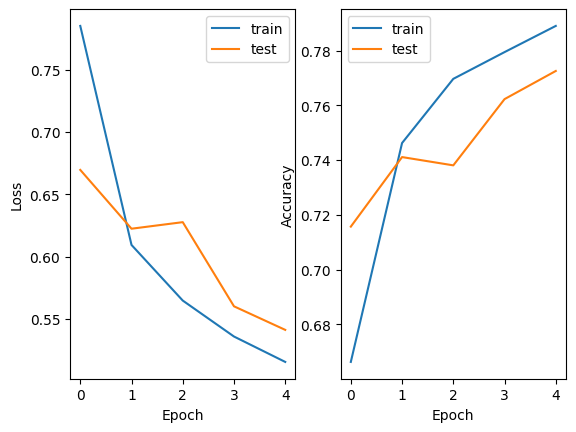

In [ ]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_cnn_agc.history_cnn_agc['loss'])
plt.plot(history_cnn_agc.history_cnn_agc['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn_agc.history_cnn_agc['accuracy'])
plt.plot(history_cnn_agc.history_cnn_agc['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])